# The problem: Cats vs Dogs

In this problem, we have to write an algorithm to classify whether images contain either a dog or a cat. This is easy for humans, dogs, and cats, but your computer will find it a bit more difficult.

<img src='https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg' />

#### The Asirra data set
Web services are often protected with a challenge that's supposed to be easy for people to solve, but difficult for computers. Such a challenge is often called a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart) or HIP (Human Interactive Proof). HIPs are used for many purposes, such as to reduce email and blog spam and prevent brute-force attacks on web site passwords.

Asirra (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately. Many even think it's fun! Here is an example of the Asirra interface:

Asirra is unique because of its partnership with Petfinder.com, the world's largest site devoted to finding homes for homeless pets. They've provided Microsoft Research with over three million images of cats and dogs, manually classified by people at thousands of animal shelters across the United States. Kaggle is fortunate to offer a subset of this data for fun and research. 
        

## Solving the problem

Let's start by getting some undestanding of the problem. This is what we know:

<ul>
    <li><b>Problem type:</b> Classification</li>
    <li><b>Number of classes:</b> 2 (cats, dogs)</li>
    <li><b>Input:</b> Images (25.000 — 50% cats, 50% dogs)</li>
</ul>

The dataset is completely balanced. 

### Introducing fast.ai

We are introducing here a framework called fast.ai (https://www.fast.ai/), a framework based on PyTorch with some handy operations already implemented to speed up problem solving quickly. To use fast.ai, we need to import 2 libraries: fastai and torch. fast.ai also has the named dataset already uploaded as part of the framework, which makes pretty convenient to work with it.

> Since fast.ai is a pretty unstable API (it changes very frequently), ensure you version is `fastai==2.4.1`. The `PyTorch` version I'm using is `torch==1.10`

In [1]:
import torch
import fastai
import numpy as np
import pandas as pd

In [2]:
from fastai.vision.all import *
from fastai.vision.data import ImageDataLoaders

The following line unzipes the compressed tar file where all the dataset is stored.

In [3]:
path = untar_data(URLs.DOGS, dest="/tmp/.fastai")
image_files = get_image_files(path)
print('Data located at:', path)

Data located at: /tmp/.fastai/dogscats


As images are unzipped in a folder, we need to create a dataset to use for training and testing. `fast.ai` has a very simple way to do that. The method `ImageDataLoader.from_folder` creates a dataset of images located in a folder. THe folder itself has a pretty peculiar structure (imagenet format) where the data is already divided in trian/test and labels are inferred from the folder containing the image (folder cats contain `cats` and folder dogs contains `dogs`.

`batch_tfms` indicates which image transformations to apply in batches to all the images, while `item_tfms` indicate which transformations will be applied individually to each image. This is useful to construct transformation pipelines right into the data loader. The ds_tfms() method quickly gets a set of random transforms that have proved to work well in a wide range of tasks in computer vision, including a random flip is applied with probability 0.5, a random rotation, a random zoom, a random lightning and contrast change and a random symmetric warp.

Finally, the function normalize creates a normalize/denormalize func using an specific mean and std. In this case, those parameters are taken from the imagenet dataset, using the values imagenet_stats which are means = [0.485, 0.456, 0.406] and stds = [0.229, 0.224, 0.225].

In [5]:
data_loader = ImageDataLoaders.from_folder(path, item_tfms=Resize(224), batch_tfms=Normalize.from_stats(*imagenet_stats))

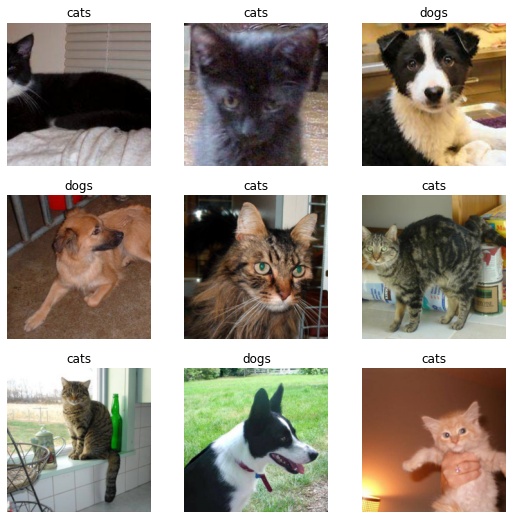

In [6]:
data_loader.train.show_batch()

### Fine tune the model

Once our dataset is ready, it's time to create our NN. CNN represents a very convenient way to solve Computer Vision problems, specially when combined with transfer learning. We use transfer learning with a pretrained image classification models to extract visual features. The idea behind it is that the representations learned for task A (typically a high-level task) are applied to task B (typically a lower-level task) as for the degree of success at task B indicates how much the task A model has learned about task B.

In [7]:
learn = cnn_learner(data_loader, models.resnet34, metrics=accuracy)

Then it's time to train. When using transfer learning, the training process is a bit different like in a normal network. In the processes we take a pre-trained model and “fine-tuning” the model with your our own dataset. The idea is that this pre-trained model will act as a feature extractor. You will remove the last layer of the network and replace it with your own classifier. You then freeze the weights of all the other layers and train the network normally

/anaconda/envs/fastai/lib/python3.8/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


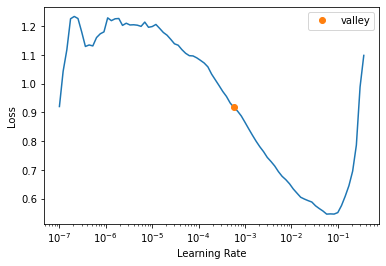

In [45]:
suggested_lr = learn.lr_find()

I'm using here the method `learn.lr_find()`. What this method does behind the scenes is running for few epochs to find out a good learning rate, where it trains from some low learning rate and increase the learning rate after each mini-batch till the loss value starts to explode. This single run provides valuable information on how well the network can be trained over a range of learning rates and what is the maximum learning rate. This is based on a paper https://arxiv.org/abs/1506.01186 which is a really good reading by the way. In Cyclical learning rates (CLR) one specifies minimum and maximum learning rate boundaries and a stepsize. The stepsize is the number of iterations (or epochs) used for each step and a cycle consists of two such steps – one in which the learning rate linearly increases from the minimum to the maximum and the other in which it linearly decreases.

We can then see which is the suggested learning rate by using the property `valley`. Let's use that to train our model.

In [46]:
learn.fine_tune(1, suggested_lr.valley)

epoch,train_loss,valid_loss,accuracy,time
0,0.103551,0.041842,0.986500,46:12


epoch,train_loss,valid_loss,accuracy,time
0,0.043503,0.026927,0.989500,1:10:13


> For simplicity, I'm only training for 1 epoch

#### (DEBUG) Loading an existing trained model instead of training

Run this code to load a version of this model that is already trained

In [8]:
import mlflow
learn = mlflow.fastai.load_model("models:/cats_vs_dogs/4")

### Saving the model

Once the model is trained, it's time to save the work. The save method will save the model and all the required files used when training. The export method will also create a pkl file which can be used later to make predictions based on new images.

In [9]:
#saved_model = learn.save('cats_vs_dogs')
saved_model = "/tmp/.fastai/dogscats/model.fastai"
learn.export(saved_model)

An important distinction here, `learn.save` will save the model itself in the `PyTorch` format, while the method `learn.export` will save both the model along with all the data transformations applied. This is important since at inference time our model expects to recive images that has been altered the same way the previous data loaded did.

### Testing the model

Let's see if the model works with an image

In [10]:
from fastai.vision.core import load_image

sample_img = load_image(image_files[1])
sample_img_arr = np.array(sample_img)

> Resizing the image is not required, as the model can do that in its pipeline trainsformation. The reason why I do this is a bit bellow.

Running the model:

In [11]:
dl_model = learn.dls.test_dl([sample_img_arr])
real_preds, _ = learn.get_preds(dl=dl_model)

In [12]:
print(real_preds)

tensor([[3.2352e-06, 1.0000e+00]])


### Tracking the experiment with mlflow

Lets's first create an experiment:

In [18]:
import mlflow

In [19]:
experiment_id = mlflow.create_experiment("mlflow-cats-vs-dogs")

We will register our model with a given signature. The model will take batches of images and will return the class probabilities of each class (in our case either cat or dog).

This means that our inputs will be tensors of shape `(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)`. Since the model expects batches of images, the right input shape is `(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS)`.

**input_schema**: Our model can handle variable image sizes, since it has a transformation that resizes the image in the process (the `Resize(224)` transformation. Then, we can indicate a variable input size using -1 in `height` and `width`. The same applies to batch size, since we can handle variable sizes.

**output_schema**: Our model will return class probabilities. Since we have 2 classes, then the out of the model has shape `(BATCH_SIZE, NUM_CLASSES)` or `(-1, 2)`.

In [20]:
import numpy as np
from mlflow.models.signature import ModelSignature
from mlflow.types.schema import Schema, TensorSpec

input_schema = Schema([
  TensorSpec(np.dtype(np.uint8), (-1, -1, -1, 3)),
])
output_schema = Schema([
  TensorSpec(np.dtype(np.float32), (-1, 2)),
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

#### Using a different loading function

There is a bug in the current implementation of the mlflow.fastai module with the flavour `pyfunc`. Until the bug is fixed, this loader module fixes the problem and allows the model to be loaded.

In [23]:
%%writefile fastai_model_loader.py
import os
import numpy as np
import pandas as pd

class _FastaiModelWrapperPatch:
    def __init__(self, learner):
        self.learner = learner

    def predict(self, dataframe):
        dl = self.learner.dls.test_dl(dataframe)
        preds, _ = self.learner.get_preds(dl=dl)
        return pd.Series(map(np.array, preds.numpy())).to_frame('predictions')

def _load_model(path):
    from fastai.learner import load_learner

    return load_learner(os.path.abspath(path))

def _load_pyfunc(path):
    """
    Load PyFunc implementation. Called by ``pyfunc.load_pyfunc``.
    :param path: Local filesystem path to the MLflow Model with the ``fastai`` flavor.
    """
    print("Model loaded from:",path)
    return _FastaiModelWrapperPatch(_load_model(path))

Overwriting fastai_model_loader.py


Let's log the model

In [24]:
with mlflow.start_run(experiment_id=experiment_id):   
    #model = mlflow.fastai.log_model(learn, "model", registered_model_name="cats_vs_dogs", signature=signature)
    model = mlflow.pyfunc.log_model("model", 
                                    registered_model_name="cats_vs_dogs", 
                                    data_path=saved_model, 
                                    code_path=["./fastai_model_loader.py"], 
                                    loader_module="fastai_model_loader", 
                                    signature=signature)

Registered model 'cats_vs_dogs' already exists. Creating a new version of this model...
2022/02/25 16:21:23 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: cats_vs_dogs, version 16
Created version '16' of model 'cats_vs_dogs'.


## Loading the model just logged in MLFLow using the pyfunc flavor.

In [13]:
serving_model_uri = model.model_uri
#serving_model_uri = 'models:/cats_vs_dogs/16'

In [31]:
mlflow_model = mlflow.pyfunc.load_model(serving_model_uri)

Model loaded from: /tmp/tmpdhodmv_d/model/data/model.fastai


Creating a sample batch

In [16]:
sample_batch = sample_img_arr.reshape(1, sample_img.height, sample_img.width,3)

In [36]:
mlflow_model.predict(sample_batch)

,predictions
0,"[3.2351693e-06, 0.9999968]"


### Running the model in a server

Starting the mlflow server. Open it in a new terminal:

```bash
mlflow models serve -m models:/cats_vs_dogs/16`
```

Creating a sample request

In [17]:
import json

with open("sample.json", "w") as f:
    f.write(json.dumps(
        {
            "instances": sample_batch.tolist()
        }
    ))

Sending the request

In [21]:
!cat -A sample.json | curl http://127.0.0.1:5000/invocations \
                        --request POST \
                        --header 'Content-Type: application/json' \
                        --data-binary @-

[{"predictions": [3.235159965697676e-06, 0.9999967813491821]}]